In [1]:
import os
import h5py
import time

import numpy as np
import matplotlib.pyplot as plt

from extra_data import open_run, RunDirectory, H5File
from extra_data.read_machinery import find_proposal

import sys
sys.path.append('../src')

from dffc import DynamicFlatFieldCorrectionCython as DynamicFlatFieldCorrection

In [2]:
def plot_corrected(im1, im2, labels):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8.5), tight_layout=True)

    i1 = ax1.matshow(im1)
    ax1.axis(False)
    fig.colorbar(i1, ax=ax1)
    ax1.set_title(labels[0])
    
    i2 = ax2.matshow(im2)
    ax2.axis(False)
    fig.colorbar(i2, ax=ax2)
    ax2.set_title(labels[1])
    
    i3 = ax3.matshow(im1/im1.mean() - im2/im2.mean())
    ax3.axis(False)
    fig.colorbar(i3, ax=ax3)
    ax3.set_title('Difference')
    
    ax4.axis(False)

In [3]:
propno = 2919
runno_dark = 59
runno_flat = 40

camno = 2
n_components = 20

downsample_factors = (2, 4)

cam_source = f"SPB_EHD_HPVX2_{camno}/CAM/CAMERA:daqOutput"

In [4]:
runno = 30

propdir = find_proposal(f"p{propno:06d}")
rundir = os.path.join(propdir, f"raw/r{runno:04d}")

tm0 = time.monotonic()
run = RunDirectory(rundir)
images = run[cam_source, "data.image.pixels"].ndarray()
ntrain, npulse, nx, ny = images.shape
tm1 = time.monotonic()

print(f"Ntrain: {ntrain}, Npulse: {npulse}, Image size: {nx} x {ny}")
print(f"N image: {ntrain * npulse}")
print(f"Read time: {tm1 - tm0:.2f} s")

Ntrain: 45, Npulse: 128, Image size: 250 x 400
N image: 5760
Read time: 2.25 s


In [5]:

fn = f"pca_cam{camno}_d{runno_dark}_f{runno_flat}_r{n_components}.h5"
dffc = DynamicFlatFieldCorrection.from_file(fn, cam_source, downsample_factors)

tm0 = time.monotonic()
imcorr1, w1, warnflag1 = dffc.process(images[0])
tm1 = time.monotonic()

print(f"Correction time: {tm1 - tm0: .2f} s, per image: {(tm1 - tm0)/128: .2f} s")

Correction time:  3.90 s, per image:  0.03 s


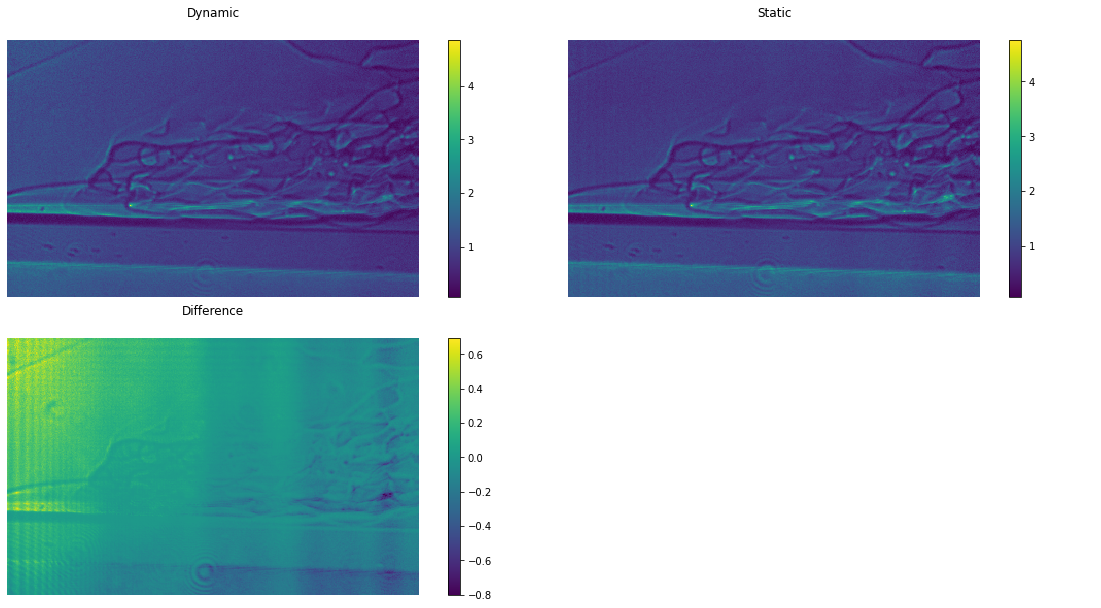

In [6]:
i = 1
#image0, flat0 = dffc.scale_and_shift(images[0, i])
image0 = dffc.scale_and_shift(images[0, i])

plot_corrected(imcorr1[i], image0 / dffc.flat, ('Dynamic', 'Static'))
plt.show()

print(np.mean(imcorr1[i]), np.mean(image0 / dffc.flat))

In [7]:
from skimage.transform import downscale_local_mean

class DynamicFlatFieldCorrectionOrig(DynamicFlatFieldCorrection):
    def downsample_scale_and_shift(self, image):
        image_ds = downscale_local_mean(image, self.downsample_factors)
        return image_ds - self.dark_ds

    def scale_and_shift(self, image):
        return image - self.dark
    
    def correct_dyn(self, w, image):
        image0 = self.scale_and_shift(image)
        flat_dyn = self.flat + np.sum(w[:, None, None] * self.components, 0)
        #flat_dyn = self.flat + np.sum(w[None, None, :] * self.components, 2)
        image_corr = image0 / flat_dyn
        return image_corr / np.mean(image_corr) * np.mean(image0 / self.flat)


In [8]:
fn = f"pca_cam{camno}_d{runno_dark}_f{runno_flat}_r{n_components}_orig.h5"
dffc_orig = DynamicFlatFieldCorrectionOrig.from_file(fn, cam_source, downsample_factors)

tm0 = time.monotonic()
imcorr2, w2, warnflag2 = dffc_orig.process(images[0])
tm1 = time.monotonic()

print(f"Correction time: {tm1 - tm0: .2f} s, per image: {(tm1 - tm0)/128: .2f} s")

0.9740975761636902 0.9674883600789408
Correction time:  4.71 s, per image:  0.04 s


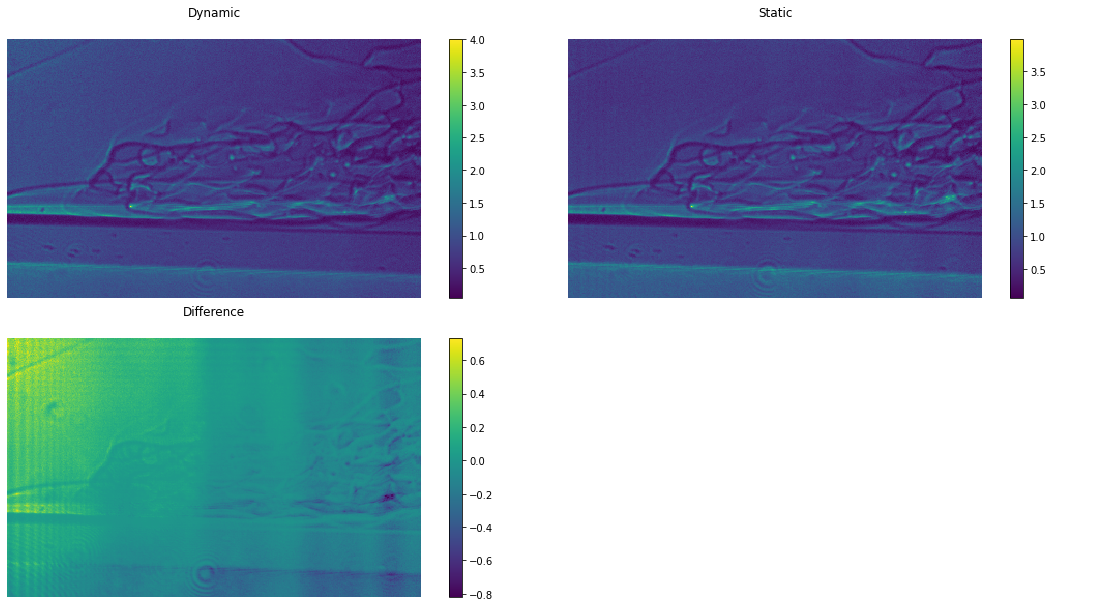

0.8100736097453302 0.8100736097453302


In [9]:
i = 1
image0 = dffc_orig.scale_and_shift(images[0, i])
plot_corrected(imcorr2[i], image0 / dffc_orig.flat, ('Dynamic', 'Static'))
plt.show()

print(np.mean(imcorr2[i]), np.mean(image0 / dffc_orig.flat))

In [10]:
import sys
sys.path.append('../onlineVisual_OnNorm')
from dffc_functions_online import *

In [11]:

nc, ny, nx = dffc_orig.components.shape

print(f"Image size: {ny} x {nx} px")
print(f"N components: {nc}")

pca_info = {
    'rank': nc,
    'image_dimensions': (nx, ny),
    'mean_flat': dffc_orig.flat,
    'mean_dark': dffc_orig.dark,
    'components_matrix': dffc_orig.components.reshape(nc, nx * ny),
}

tm0 = time.monotonic()
imcorr3 = dffc_correct(images[0], pca_info, downsample_factors, fctr=10000000000.0, x0_last=False)
tm1 = time.monotonic()

print(f"Minimization time: {tm1 - tm0: .2f} s, per image: {(tm1 - tm0)/128: .2f} s")
    

Image size: 250 x 400 px
N components: 21


/home/esobolev/envs/dev/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:99: RuntimeWarning: divide by zero encountered in power
  defvjp(anp.sqrt,    lambda ans, x : lambda g: g * 0.5 * x**-0.5)
/home/esobolev/envs/dev/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:59: RuntimeWarning: invalid value encountered in multiply
  lambda ans, x, y : unbroadcast_f(x, lambda g: g * y * x ** anp.where(y, y - 1, 1.)),


Minimization time:  10.72 s, per image:  0.08 s


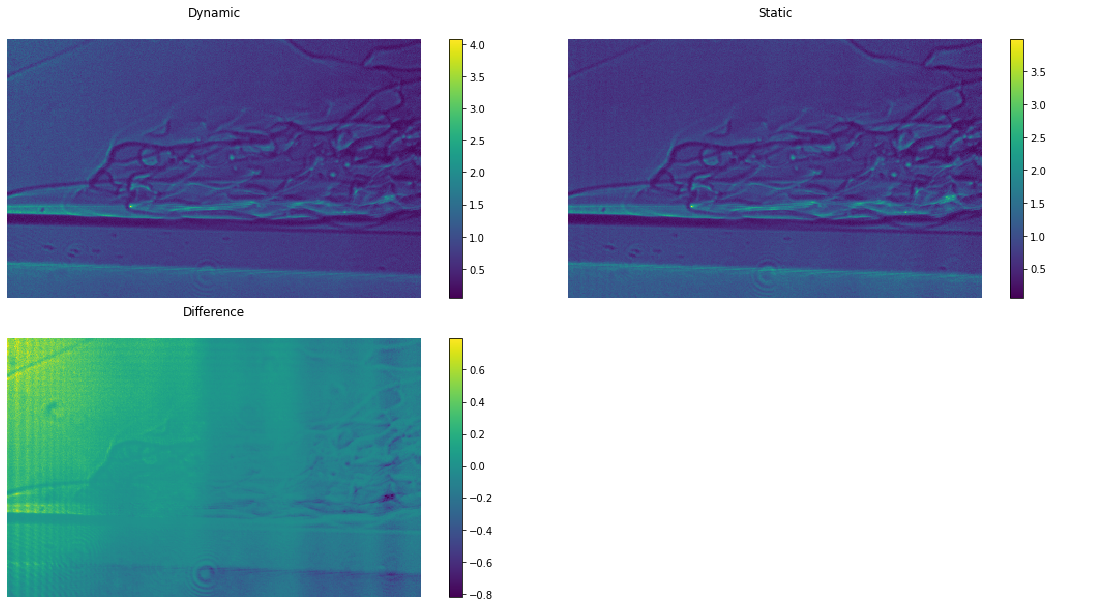

In [12]:
i = 1
image0 = dffc_orig.scale_and_shift(images[0, i])
plot_corrected(imcorr3[i], image0 / dffc_orig.flat, ('Dynamic', 'Static'))
plt.show()

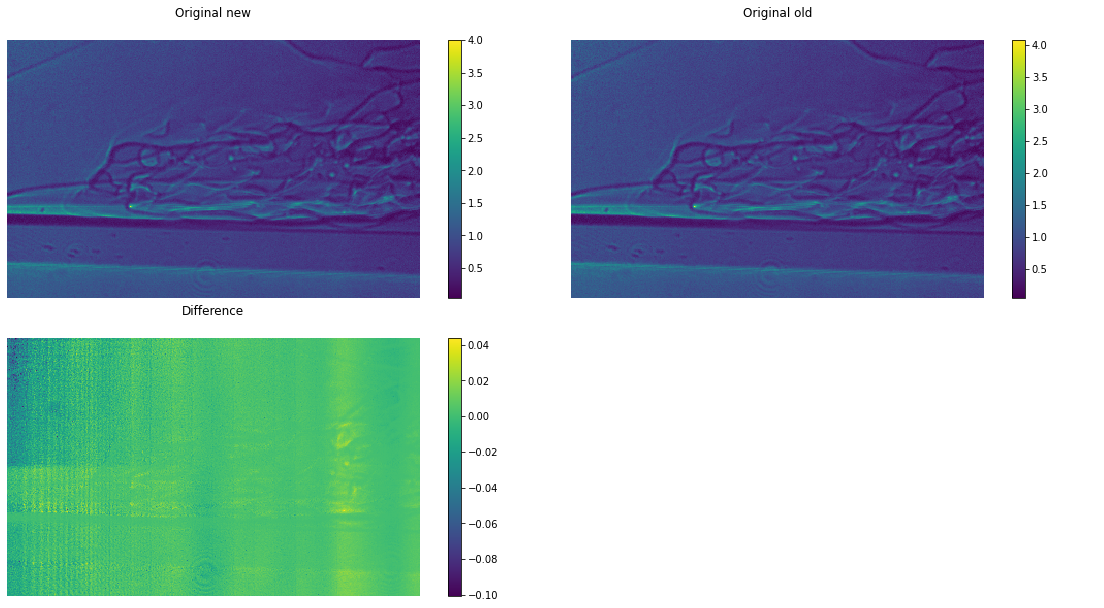

In [13]:
i = 1
plot_corrected(imcorr2[i], imcorr3[i], ('Original new', 'Original old'))
plt.show()

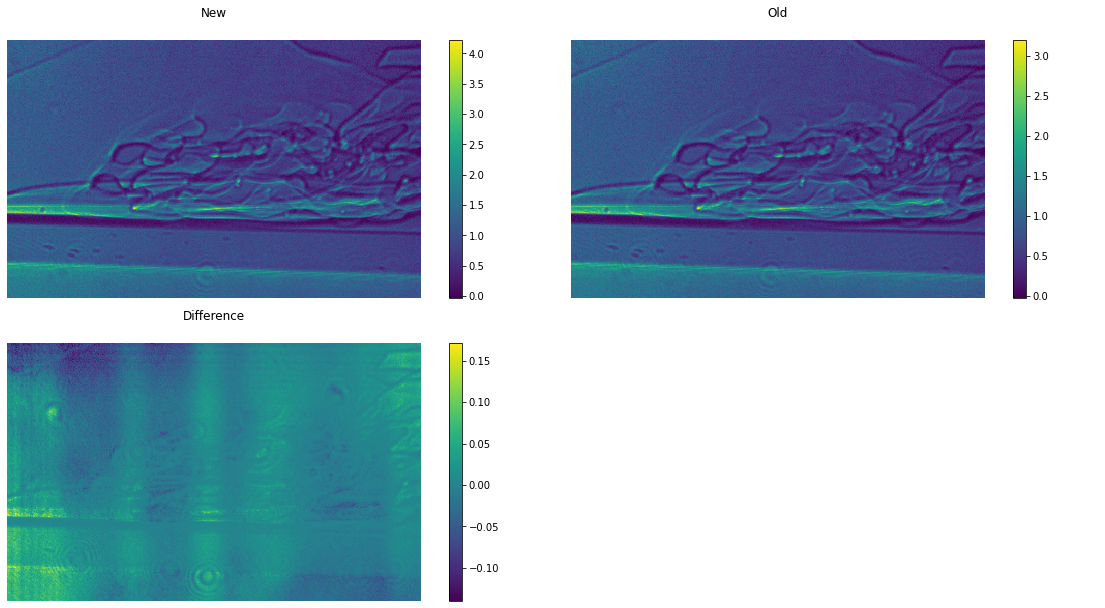

In [14]:
i = 10
plot_corrected(imcorr1[i], imcorr2[i], ('New', 'Old'))
plt.show()

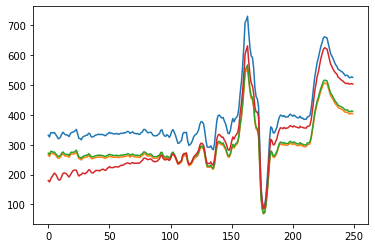

In [15]:
plt.plot(imcorr1[i].sum(1))
plt.plot(imcorr2[i].sum(1))
plt.plot(imcorr3[i].sum(1))
plt.plot(images[0][i].sum(1)/4000)

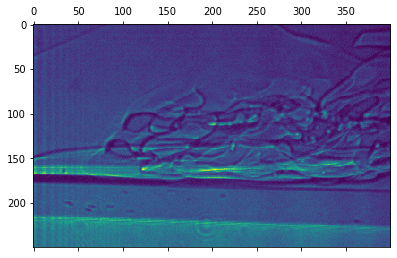

In [16]:
plt.matshow(images[0][i])